In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az
az.style.use('arviz-darkgrid')

In [2]:
np.random.seed(123)
trials = 4
theta_real = 0.35 # unknown value in a real experiment
data = stats.bernoulli.rvs(p=theta_real, size=trials)
data

array([1, 0, 0, 0])

In [3]:
with pm.Model() as our_first_model:
    # a priori
    theta = pm.Beta('theta', alpha=1., beta=1.)
    # likelihood
    y = pm.Bernoulli('y', p=theta, observed=data)
    trace = pm.sample(1000, random_seed=123,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:01<00:00, 5874.97draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c34cd84a8>,
      dtype=object)

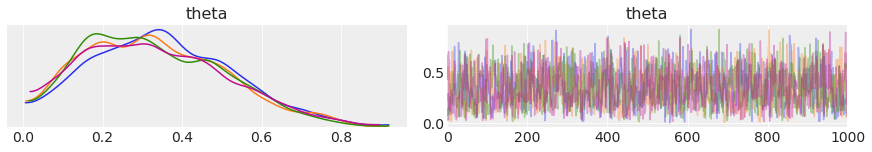

In [4]:
az.plot_trace(trace)

In [5]:
az.summary(trace)

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
theta,0.34,0.18,0.01,0.04,0.66,1547.0,1.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c383d2588>],
      dtype=object)

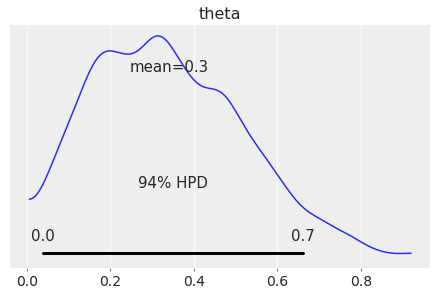

In [6]:
az.plot_posterior(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c38133390>],
      dtype=object)

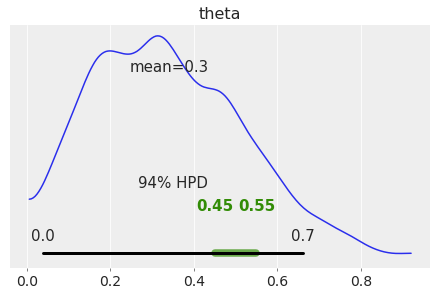

In [7]:
az.plot_posterior(trace, rope=[0.45, .55])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c35f20438>],
      dtype=object)

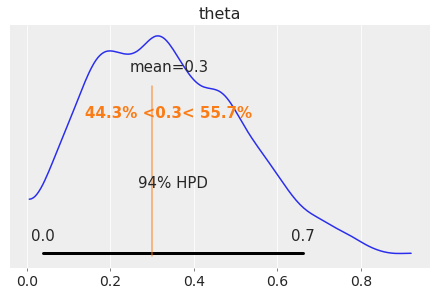

In [8]:
az.plot_posterior(trace, ref_val=0.3) 

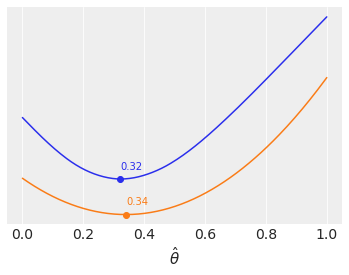

In [9]:
grid = np.linspace(0, 1, 200)
theta_pos = trace['theta']
lossf_a = [np.mean(abs(i - theta_pos)) for i in grid]
lossf_b = [np.mean((i - theta_pos)**2) for i in grid]

for lossf, c in zip([lossf_a, lossf_b], ['C0', 'C1']):
    mini = np.argmin(lossf)
    plt.plot(grid, lossf, c)
    plt.plot(grid[mini], lossf[mini], 'o', color=c)
    plt.annotate('{:.2f}'.format(grid[mini]),
                 (grid[mini], lossf[mini] + 0.03), color=c)
    plt.yticks([])
    plt.xlabel(r'$\hat \theta$')

Text(0.5, 0, '$\\hat \\theta$')

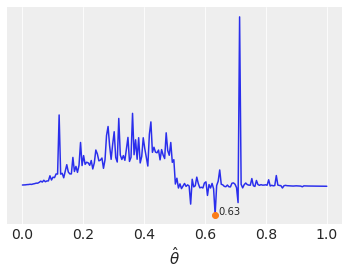

In [10]:
lossf = []
for i in grid:
    if i < 0.5:
        f = np.mean(np.pi * theta_pos / np.abs(i - theta_pos))
    else:
        f = np.mean(1 / (i - theta_pos))
    lossf.append(f)

mini = np.argmin(lossf)
plt.plot(grid, lossf)
plt.plot(grid[mini], lossf[mini], 'o')
plt.annotate('{:.2f}'.format(grid[mini]),
             (grid[mini] + 0.01, lossf[mini] + 0.1))
plt.yticks([])
plt.xlabel(r'$\hat \theta$')

([<matplotlib.axis.YTick at 0x1c35e06dd8>],
 <a list of 1 Text yticklabel objects>)

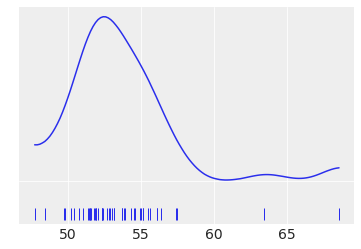

In [11]:
data = pd.read_csv('../data/chemical_shifts.csv',header=None)
az.plot_kde(data,rug=True)
plt.yticks([0], alpha=0)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c352728d0>],
      dtype=object)

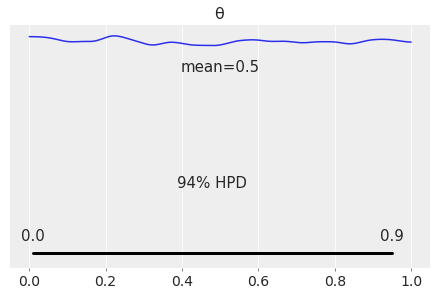

In [12]:
np.random.seed(1)
az.plot_posterior({'θ':stats.uniform.rvs(0,1, size=100000)})

In [13]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ',lower=40,upper=70)
    σ = pm.HalfNormal('σ',sd =10)
    y = pm.Normal('y',mu = μ, sd = σ, observed = data)
    trace_g = pm.sample(1000,chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [σ, μ]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:00<00:00, 3085.92draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c35cd76d8>,
      dtype=object)

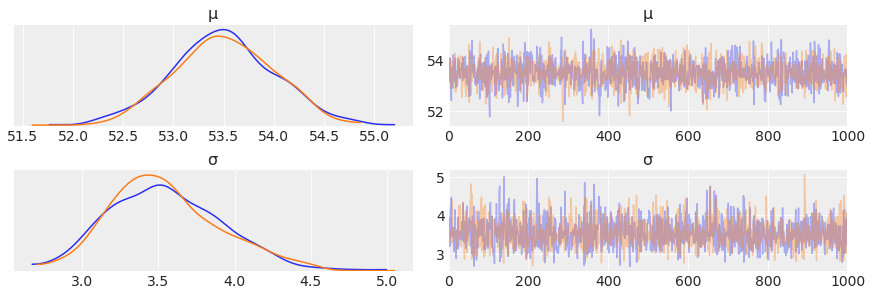

In [14]:
az.plot_trace(trace_g)

(<matplotlib.axes._subplots.AxesSubplot at 0x1c38df0438>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c39c92c88>)

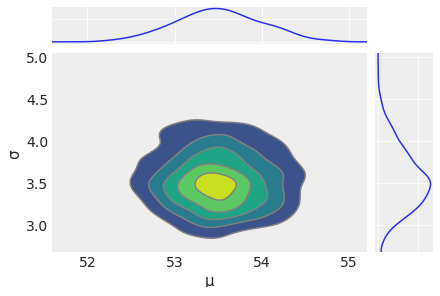

In [15]:
az.plot_joint(trace_g,kind= 'kde',fill_last=False)

In [16]:
az.summary(trace_g)

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
μ,53.49,0.51,0.01,52.53,54.39,1957.0,1.0
σ,3.55,0.37,0.01,2.89,4.24,1762.0,1.0


In [17]:
y_pred_g = pm.sample_posterior_predictive(trace_g,100,model_g)

100%|██████████| 100/100 [00:00<00:00, 1601.08it/s]


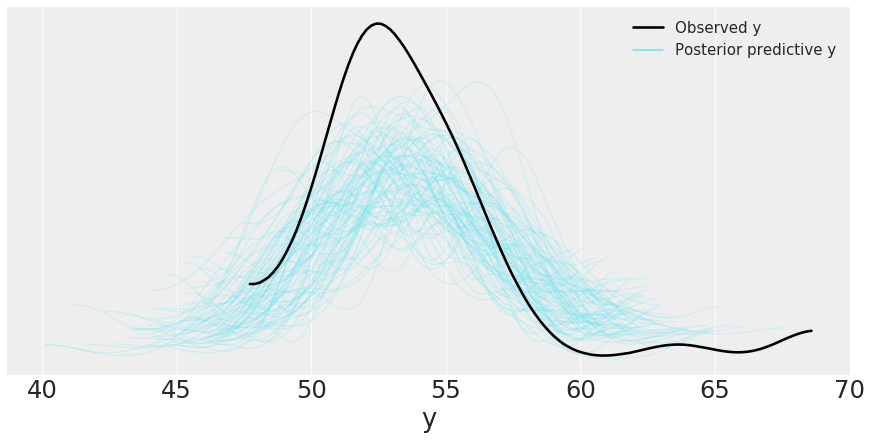

In [18]:
data_ppc = az.from_pymc3(trace=trace_g, posterior_predictive=y_pred_g)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=False)
ax[0].legend(fontsize=15)

In [19]:
np.mean(stats.t(loc=0, scale=1, df=100000).rvs(100))

-0.06973887624950587

(-5, 5)

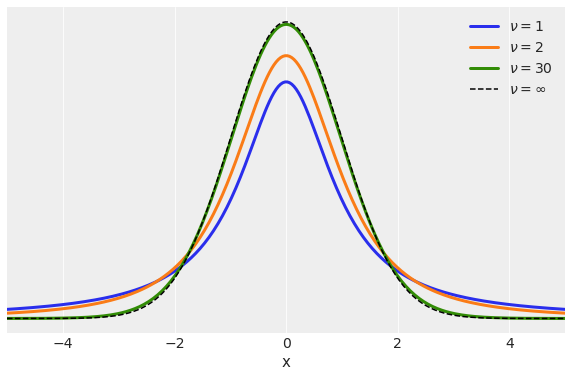

In [20]:
plt.figure(figsize=(10, 6))
x_values = np.linspace(-10, 10, 500)
for df in [1, 2, 30]:
    distri = stats.t(df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label=fr'$\nu = {df}$', lw=3)

x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, 'k--', label=r'$\nu = \infty$')
plt.xlabel('x')
plt.yticks([])
plt.legend()
plt.xlim(-5, 5)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, σ, μ]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 3609.93draws/s]
The acceptance probability does not match the target. It is 0.8874135412272367, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c3abb35c0>,
      dtype=object)

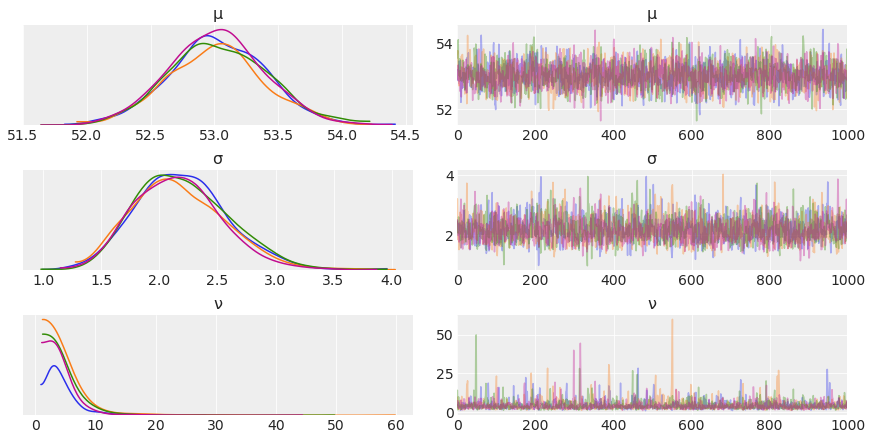

In [21]:
with pm.Model() as model_t:
    μ = pm.Uniform('μ', 40, 75)
    σ = pm.HalfNormal('σ', sd=10)
    ν = pm.Exponential('ν', 1/30)
    y = pm.StudentT('y', mu=μ, sd=σ, nu=ν, observed=data)
    trace_t = pm.sample(1000)
az.plot_trace(trace_t)

In [22]:
az.summary(trace_t)

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
μ,53.02,0.38,0.00,52.32,53.74,2640.0,1.0
σ,2.18,0.40,0.01,1.46,2.90,2417.0,1.0
ν,4.51,3.41,0.09,1.20,9.34,1919.0,1.0


100%|██████████| 100/100 [00:00<00:00, 2306.49it/s]


(40, 70)

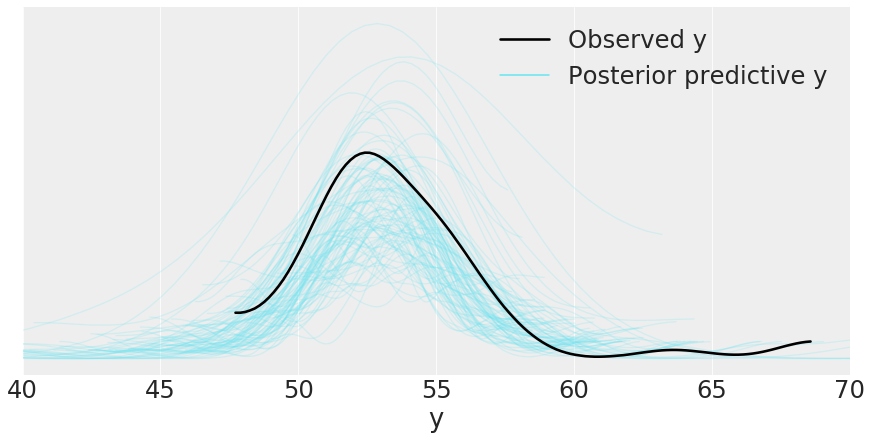

In [23]:
y_ppc_t = pm.sample_posterior_predictive(
    trace_t, 100, model_t, random_seed=123)
y_pred_t = az.from_pymc3(trace=trace_t, posterior_predictive=y_ppc_t)
az.plot_ppc(y_pred_t, figsize=(12, 6), mean=False)
ax[0].legend(fontsize=15)
plt.xlim(40, 70)

In [24]:
tips = pd.read_csv('../data/tips.csv')
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


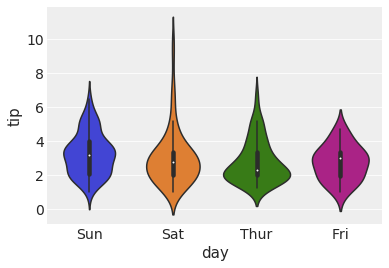

In [25]:
sns.violinplot(x='day', y='tip', data=tips)

In [26]:
tip = tips['tip'].values
idx = pd.Categorical(tips['day'],categories=['Thur','Fri','Sat','Sun']).codes
groups = len(np.unique(idx))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [σ, μ]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:08<00:00, 1351.59draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c401e1898>,
      dtype=object)

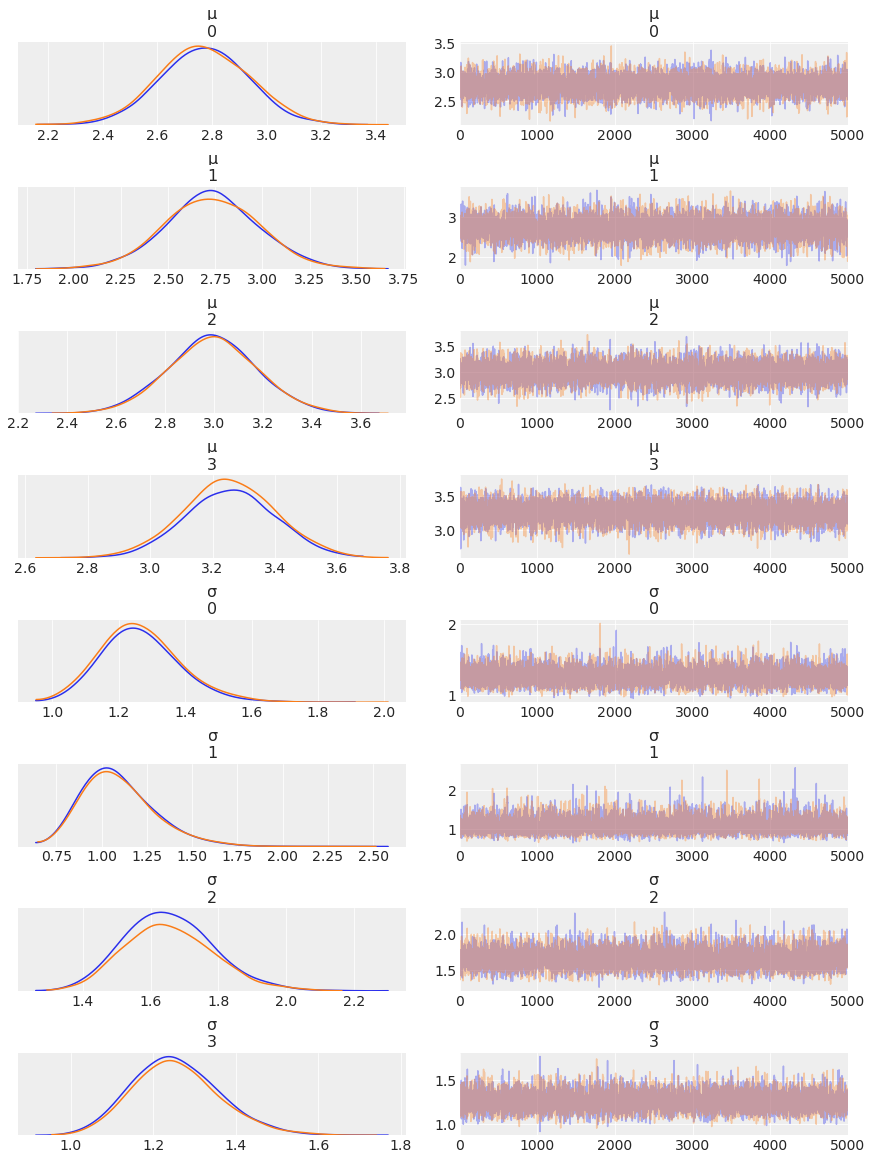

In [27]:
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=tip)

    trace_cg = pm.sample(5000,chains=2)
az.plot_trace(trace_cg)

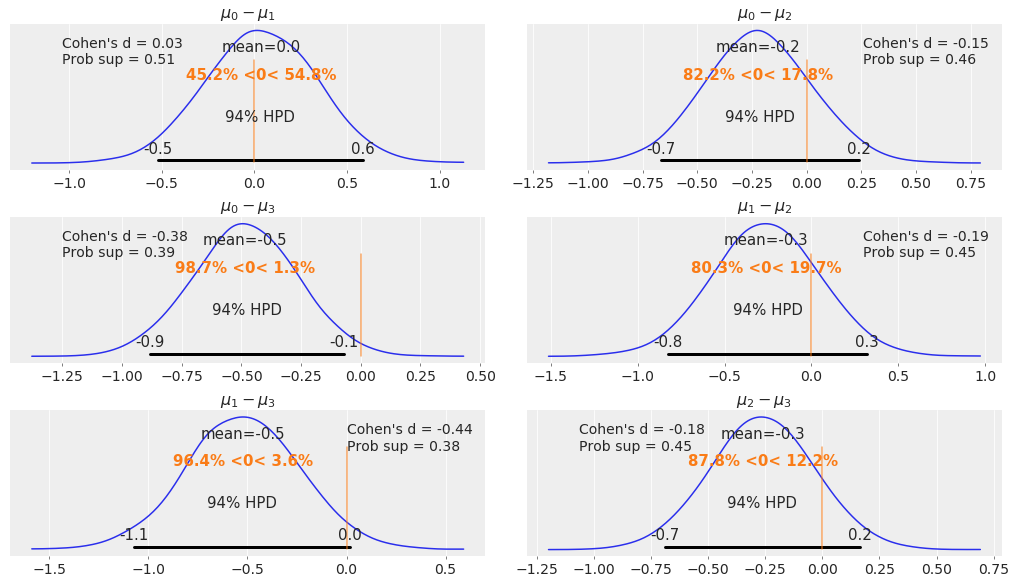

In [28]:
dist = stats.norm()

_, ax = plt.subplots(3, 2, figsize=(14, 8), constrained_layout=True)

comparisons = [(i, j) for i in range(4) for j in range(i+1, 4)]
pos = [(k, l) for k in range(3) for l in (0, 1)]

for (i, j), (k, l) in zip(comparisons, pos):
    means_diff = trace_cg['μ'][:, i] - trace_cg['μ'][:, j]
    d_cohen = (means_diff / np.sqrt((trace_cg['σ'][:, i]**2 + trace_cg['σ'][:, j]**2) / 2)).mean()
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff, ref_val=0, ax=ax[k, l])
    ax[k, l].set_title(f'$\mu_{i}-\mu_{j}$')
    ax[k, l].plot(
        0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax[k, l].legend()

In [30]:
N_samples = [30, 30, 30]
G_samples = [18, 18, 18]

group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))
    
